In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from termcolor import colored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/semantic_drone_dataset/original_images/')
mask_path = os.path.join(path, '/content/drive/MyDrive/semantic_drone_dataset/label_images_semantic/')

In [ ]:
image_list = os.listdir(image_path)
im_list = image_list
mask_list = os.listdir(mask_path)

In [ ]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in im_list]

for x in range(0,400):
    mask_list[x] = mask_list[x][:-4] + '.png'

Text(0.5, 1.0, 'Segmentation')

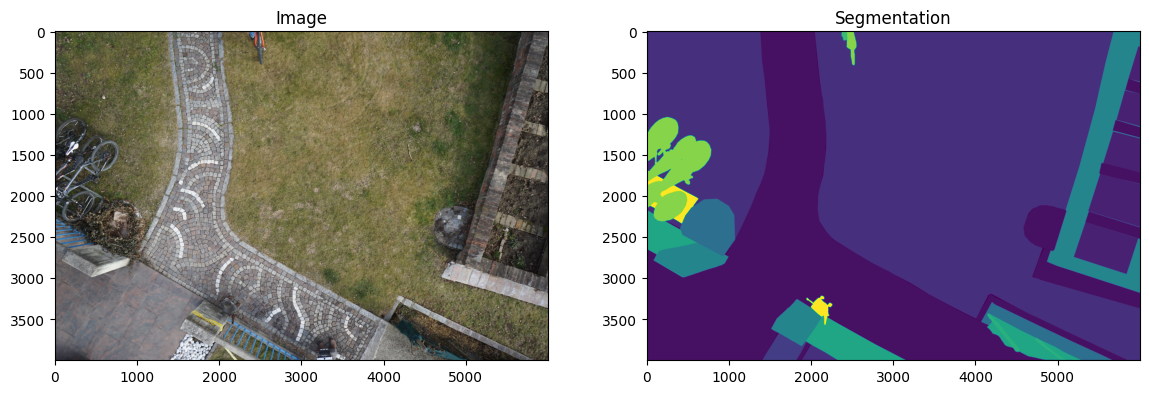

In [ ]:
N = 56
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [ ]:
import tensorflow as tf
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic_drone_dataset/original_images/000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic_drone_dataset/label_images_semantic/000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic_drone_dataset/original_images/001.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic_drone_dataset/label_images_semantic/001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic_drone_dataset/original_images/002.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic_drone_dataset/label_images_semantic/002.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/semantic_drone_dataset/original_images/002.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/semantic_drone_dataset/label_images_semantic/002.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
input_size=(256, 256, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 256, 256, 3)], 0],
            ['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

#comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 256, 256, 3)], 0],
            ['Conv2D', (None, 256, 256, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 256, 256, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 256, 256, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 128, 128, 1024), 0, (2, 2)]]

print('\nBlock 2:')
for layer in summary(model2):
    print(layer)

#comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 256, 256, 3)], 0]
['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)]

Block 2:
['InputLayer', [(None, 256, 256, 3)], 0]
['Conv2D', (None, 256, 256, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 256, 256, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 256, 256, 1024), 0, 0.1]
['MaxPooling2D', (None, 128, 128, 1024), 0, (2, 2)]


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,
                 3,
                 strides=2,
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [ ]:
input_size1=(32, 32, 256)
input_size2 = (64, 64, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 32, 32, 256)], 0],
            ['Conv2DTranspose', (None, 64, 64, 32), 73760],
            ['InputLayer', [(None, 64, 64, 128)], 0],
            ['Concatenate', (None, 64, 64, 160), 0],
            ['Conv2D', (None, 64, 64, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 64, 64, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

#comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 32, 32, 256)], 0]
['Conv2DTranspose', (None, 64, 64, 32), 73760]
['InputLayer', [(None, 64, 64, 128)], 0]
['Concatenate', (None, 64, 64, 160), 0]
['Conv2D', (None, 64, 64, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 64, 64, 32), 9248, 'same', 'relu', 'HeNormal']


In [ ]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)

    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=None)

    ublock6 = upsampling_block(cblock5[0],cblock4[1] ,  n_filters * 8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
unet_model_output = [['InputLayer', [(None, 256, 256, 3)], 0],
['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)],
['Conv2D', (None, 128, 128, 64), 18496, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 128, 128, 64), 36928, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 64, 64, 64), 0, (2, 2)],
['Conv2D', (None, 64, 64, 128), 73856, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 64, 64, 128), 147584, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 32, 32, 128), 0, (2, 2)],
['Conv2D', (None, 32, 32, 256), 295168, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 32, 32, 256), 590080, 'same', 'relu', 'HeNormal'],
['Dropout', (None, 32, 32, 256), 0, 0.3],
['MaxPooling2D', (None, 16, 16, 256), 0, (2, 2)],
['Conv2D', (None, 16, 16, 512), 1180160, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 16, 16, 512), 2359808, 'same', 'relu', 'HeNormal'],
['Dropout', (None, 16, 16, 512), 0, 0.3],
['Conv2DTranspose', (None, 32, 32, 256), 1179904],
['Concatenate', (None, 32, 32, 512), 0],
['Conv2D', (None, 32, 32, 256), 1179904, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 32, 32, 256), 590080, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 64, 64, 128), 295040],
['Concatenate', (None, 64, 64, 256), 0],
['Conv2D', (None, 64, 64, 128), 295040, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 64, 64, 128), 147584, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 128, 128, 64), 73792],
['Concatenate', (None, 128, 128, 128), 0],
['Conv2D', (None, 128, 128, 64), 73792, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 128, 128, 64), 36928, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 256, 256, 32), 18464],
['Concatenate', (None, 256, 256, 64), 0],
['Conv2D', (None, 256, 256, 32), 18464, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 23), 759, 'same', 'linear', 'GlorotUniform']]

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
#comparator(summary(unet), unet_model_output)

In [ ]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d_6[0][0]']               
                                )                                                           

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(4000, 6000, 1)


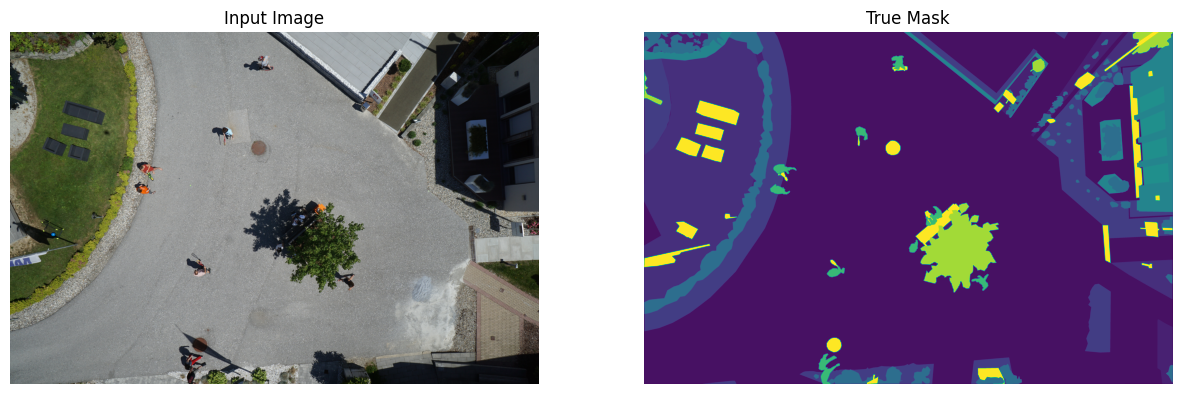

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(256, 256, 1)


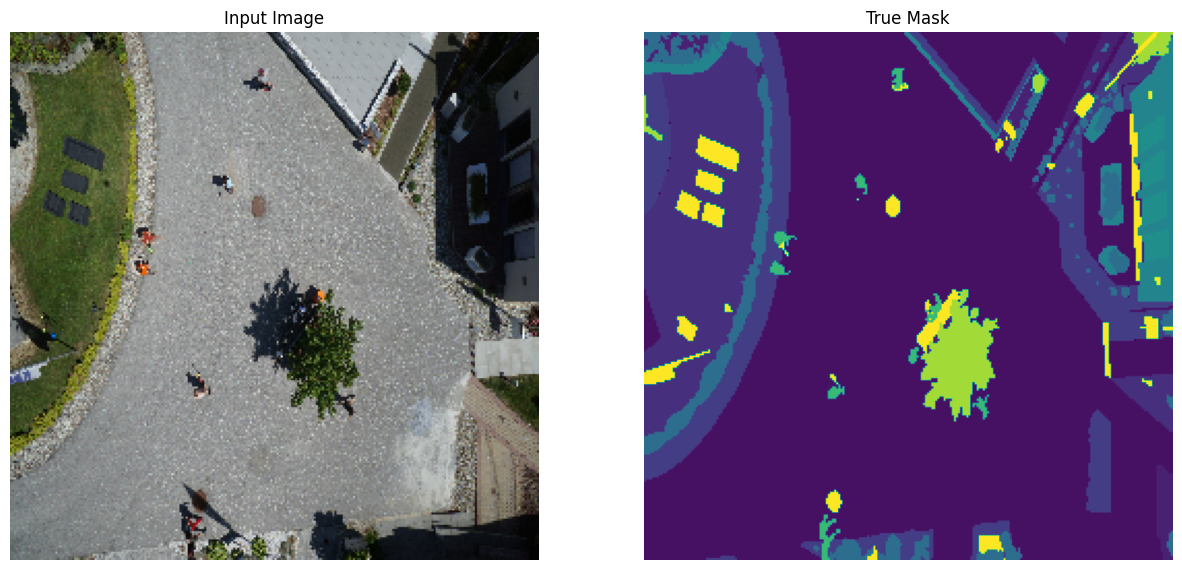

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  unet = unet_model((img_height, img_width, num_channels))
  unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
EPOCHS = 350
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds=processed_image_ds.shuffle(BUFFER_SIZE)

ts=len(processed_image_ds)
val_dataset=processed_image_ds.skip(int(ts*0.8))
train_dataset=processed_image_ds.take(int(ts*0.8))

print(len(val_dataset))
print(len(train_dataset))

val_dataset.batch(BATCH_SIZE)
train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(len(val_dataset))
print(len(train_dataset))
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[es])

80
320
3
10
(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/350
10/10 [==============================] - 871s 29s/step - loss: 2.8042 - accuracy: 0.2783 - val_loss: 2.3069 - val_accuracy: 0.4048
Epoch 2/350
10/10 [==============================] - 9s 863ms/step - loss: 2.2221 - accuracy: 0.4364 - val_loss: 1.9381 - val_accuracy: 0.5174
Epoch 3/350
10/10 [==============================] - 8s 845ms/step - loss: 1.9144 - accuracy: 0.5163 - val_loss: 1.7213 - val_accuracy: 0.5557
Epoch 4/350
10/10 [==============================] - 8s 855ms/step - loss: 1.7622 - accuracy: 0.5304 - val_loss: 1.6471 - val_accuracy: 0.5564
Epoch 5/350
10/10 [==============================] - 9s 882ms/step - loss: 1.6643 - accuracy: 0.5437 - val_loss: 1.5424 - val_accuracy: 0.5653
Epoch 6/350
10/10 [==============================] - 9s 860ms/step - loss: 1.5993 - accuracy: 0.5558 - val_loss: 1.6595 - val_accuracy: 0.5336
Epoch 7

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

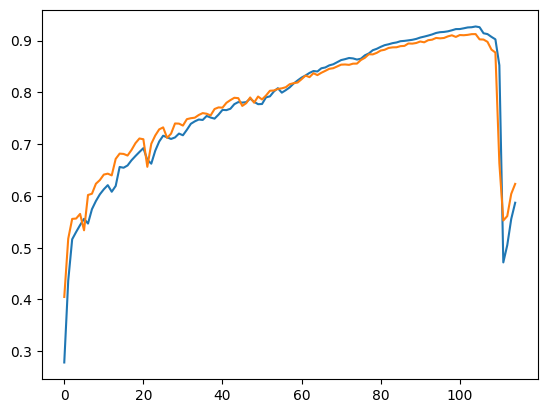

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

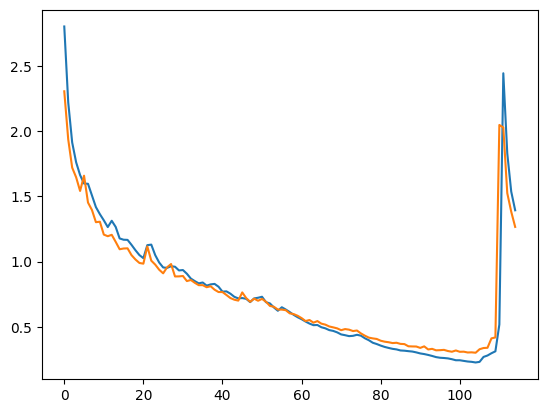

In [ ]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 847ms/step


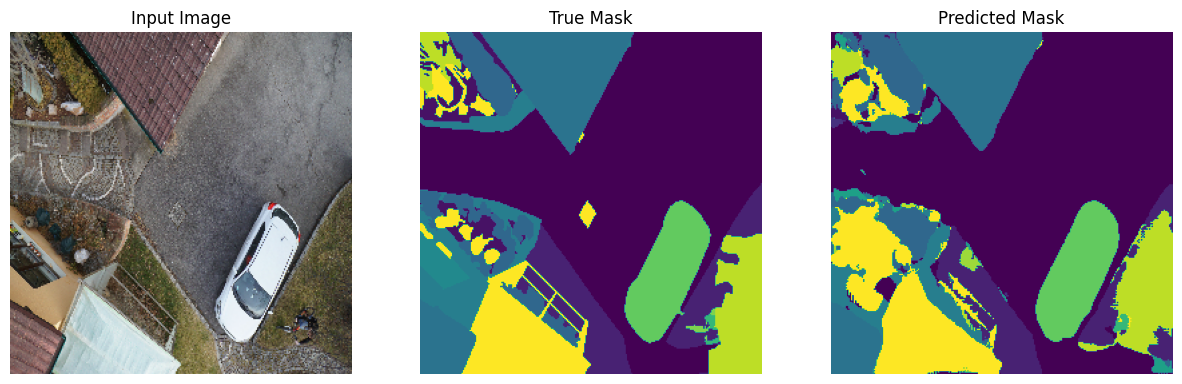

1/1 [==============================] - 0s 87ms/step


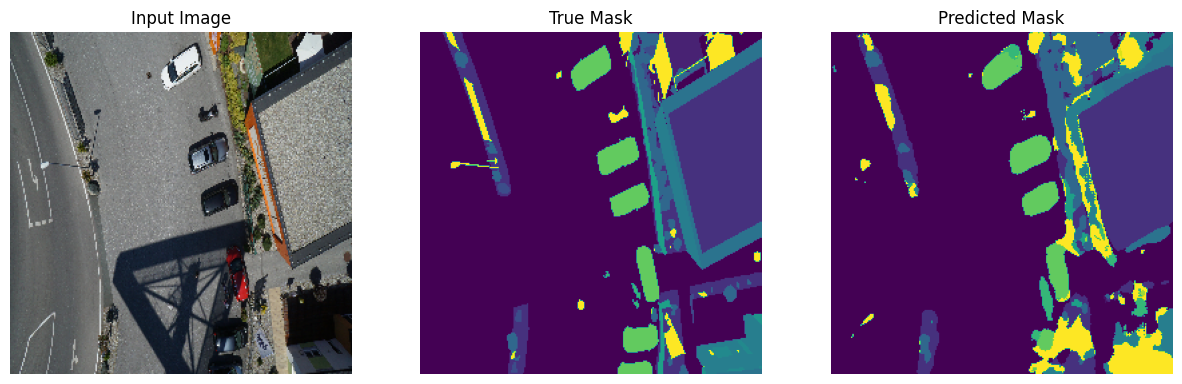

1/1 [==============================] - 0s 333ms/step


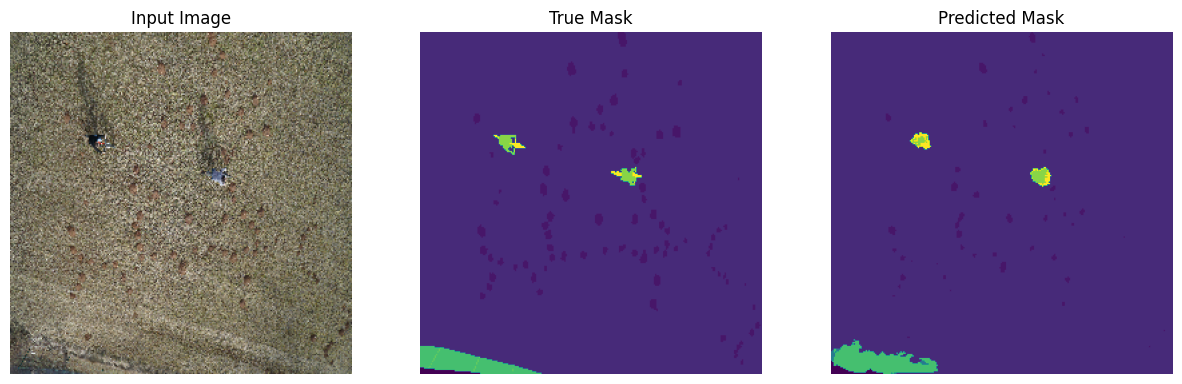

In [ ]:
show_predictions(val_dataset, 3)